# Model Predictive Control (MPC) for the Mountain Car

## Exercise 1
In this exercise, you will implement **Model Predictive Control (MPC)** using a **random shooting method** to solve the **Mountain Car** problem.

You will complete the `mpc_action()` function, which chooses the best action sequence by simulating multiple random trajectories into the future and selecting the one with the lowest total cost.

---

## ⚙️ Environment Description
You are working with a **simplified Mountain Car** environment, where the goal is to reach and stay near the top of the right hill (`x ≈ 0.45`).

The car’s state is:
- `x` → position  
- `v` → velocity  

The control input is:
- `u` → engine thrust in the range `[-1, 1]`

The dynamics are defined as:
\[
v_{t+1} = v_t + 0.0015 u_t - 0.0025 \cos(3x_t)
\]
\[
x_{t+1} = x_t + v_{t+1}
\]

---

## 🚀 Task
Your task is to **implement mpc_action function for the MPC controller**.

At each step:
1. You will **sample random sequences of actions** for the next `H` steps.
2. You will **simulate** the effect of each sequence on the system using a provided dynamics model.
3. You will **compute the total cost** of each simulated trajectory.
4. You will **choose the best trajectory** (lowest cost) and apply its first action.

---

## ✅ Deliverables
* The completed mpc_action() function.
* A short report (few paragraphs) answering:
    * How does random shooting choose the best action?
    * How does changing H or N_seq affect the result?
    * Did your car reach and stay near the goal?

In [1]:
%matplotlib inline

# Setup environment and collect initial data

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------------------
# Environment setup
# --------------------------------------------------------------
env = gym.make("MountainCarContinuous-v0", max_episode_steps=500)

### Dynamics
This is the underneath dynamics in the mountain car. For this exercise, we will use it, but for the following sessions, **we will learn it!**

In [3]:
def mountain_car_dynamics(p, v, a):
    v_next = v + 0.001 * a - 0.0025 * np.cos(3 * p)
    v_next = np.clip(v_next, -0.07, 0.07)
    p_next = p + v_next
    if p_next < -1.2:
        p_next, v_next = -1.2, 0.0
    return np.array([p_next, v_next])

# Test dynamics, at position p, and velocity v, predict the new location when the action a=1 is applied.
mountain_car_dynamics(p=-0.5, v=0, a=1.0)

array([-0.49917684,  0.00082316])

### Cost function

In [4]:
def cost_fn(state, a):
    x, v = state
    goal = 0.5
    target = goal - x

    # Encourage moving in the right direction and gaining kinetic energy
    cost = target**2 - 1000 * np.abs(v)
    return cost

## Roll out trajectories based on action sequences U

In [5]:
def roll_out_trajectory(s0, Ui, gamma=1.0):
    s = s0.copy()  # Initial state
    traj = [s0.copy()]  # Trajectory
    H = len(Ui)
    discount = 1.0

    total_cost = 0.0

    # For each time in the planning horizon
    for k in range(H):
        a = Ui[k]  # continuous action in [-1, 1]
        delta_m = np.zeros(2)

        # Predict Δx using both GPs (for Δp, Δv)
        s = mountain_car_dynamics(s[0], s[1], a)
        traj.append(s.copy())

        # Accumulate discounted cost
        total_cost += cost_fn(s, a) * discount
        discount *= gamma
    return np.array(traj), total_cost


def roll_out_n_trajectories(state, U):
    N_seq = len(U)
    J = np.zeros(N_seq)

    # Roll out trajectories and computer their cost
    all_traj = []
    for i in range(N_seq):
        traj, total_cost = roll_out_trajectory(state, U[i])

        J[i] = total_cost
        all_traj.append(np.array(traj))

    return all_traj, J

# Action squence
Ui = np.zeros(3)
traj, J = roll_out_trajectory(np.array([-0.5,0]), Ui)
traj

array([[-5.00000000e-01,  0.00000000e+00],
       [-5.00176843e-01, -1.76843004e-04],
       [-5.00529206e-01, -3.52362983e-04],
       [-5.01054453e-01, -5.25246664e-04]])

In [6]:
def plot_trajectories(state, best_traj):
    plt.figure(figsize=(8, 6))
    for i, traj in enumerate(best_traj):
        plt.plot(traj[:, 0], traj[:, 1], lw=2, alpha=0.8, label=f"Traj {i+1}")
    plt.scatter(state[0], state[1], color='red', s=60, label="Start", zorder=5)
    plt.axvline(0.5, color='gray', ls='--', label='Goal position')
    plt.xlabel("Position")
    plt.ylabel("Velocity")
    plt.title(f"Predicted Trajectories (Continuous MPC)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Finding optimal action for MPC (Random Shooting)

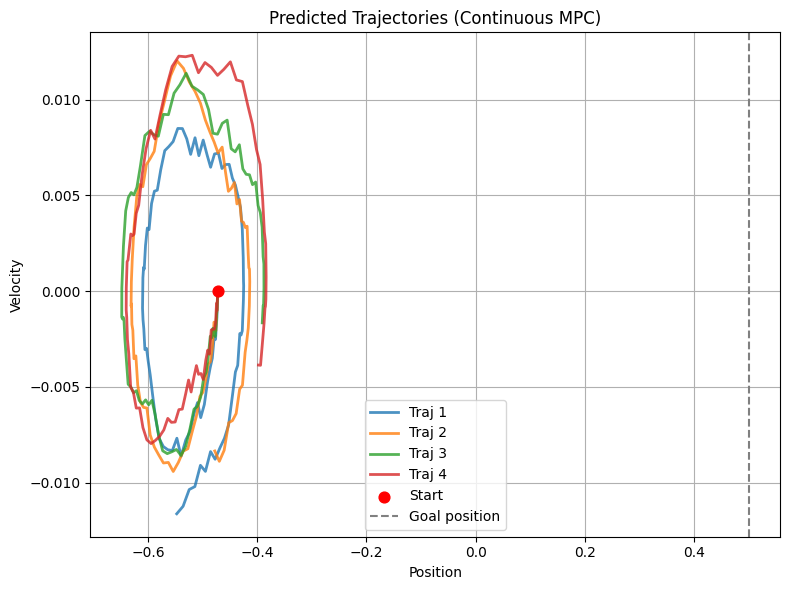

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# --------------------------------------------------------------
#  MPC (Random Shooting)
# --------------------------------------------------------------

def mpc_action(state, H=25, N_seq=200, plot=False, plot_best=10, repeat=5):
    """
    Random Shooting MPC for continuous actions in [-1, 1].
    Each GP predicts Δposition and Δvelocity given (pos, vel, action).
    """

    ########### TODO ####################
    # 1. Sample action sequences
    # action_seqs[i] = sequence of H actions
    action_seqs = np.random.uniform(-1, 1, size=(N_seq, H))

    # 2. Roll out trajectories
    # returns:
    #   all_traj[i] = list of [obs, action]
    #   costs[i]    = total cost of trajectory i
    all_traj, costs = roll_out_n_trajectories(state, action_seqs)

    # 3. Select top trajectories
    k = max(1, min(plot_best, N_seq))
    best_idx = np.argpartition(costs, k - 1)[:k]

    # Plot the best predicted trajectories
    if plot:
        best_traj_list = [all_traj[j] for j in best_idx]
        plot_trajectories(state, best_traj_list)

    # 4. Return the first action of the best sequence
    # best_idx[0] is lowest-cost sequence
    best_action = float(action_seqs[best_idx[0], 0])
    return best_action


obs, _ = env.reset(seed=0)
a = mpc_action(obs, H=80, N_seq=100, plot=True, plot_best=4)


In [13]:
# --------------------------------------------------------------
# Running in the gym environment
# --------------------------------------------------------------
H = 80        # MPC horizon
N_seq = 200   # Number of sampled action sequences
steps = 500   # Max episode length


obs, _ = env.reset()
returns = 0.0
a = 0.0       # initial action

trajectory = []

for t in range(steps):
    # --- 1. Compute optimal action via MPC ---
    a = mpc_action(obs, H=H, N_seq=N_seq)

    if t%10==0:
        print("t=",t, "state=", obs, "a=",a)

    # --- 2. Step environment ---
    next_obs, r, term, trunc, _ = env.step([a])  # continuous env expects array-like
    trajectory.append([obs,a])
    env.render()  # draw each step

    returns += r

    # --- 5. Prepare next step ---
    obs = next_obs
    if term or trunc:
        break

print(f"Episode return: {returns:.2f}")
env.close()


t= 0 state= [-0.5460427  0.       ] a= 0.991803098780772


c:\Users\zakik\AppData\Local\Programs\Python\Python312\Lib\site-packages\gymnasium\envs\classic_control\continuous_mountain_car.py:202: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("MountainCarContinuous-v0", render_mode="rgb_array")
  gym.logger.warn(


t= 10 state= [-0.51186556  0.00685173] a= 0.7580143940227535
t= 20 state= [-0.4303185   0.00756396] a= 0.8908572780641986
t= 30 state= [-0.36311567  0.00452583] a= -0.7926513774243356
t= 40 state= [-0.37730536 -0.00574953] a= -0.25655711781848267
t= 50 state= [-0.51654446 -0.01824981] a= -0.9888464052801764
t= 60 state= [-0.7168484  -0.01909218] a= 0.9757662245975676
t= 70 state= [-0.81957865 -0.00344925] a= -0.16694997260148314
t= 80 state= [-0.7352215   0.01852061] a= 0.8340649346578317
t= 90 state= [-0.4726384   0.03078316] a= 0.4794205271339893
t= 100 state= [-0.18304463  0.0232286 ] a= 0.8430534479290015
t= 110 state= [-0.05675134  0.00071942] a= -0.7743151267715433
t= 120 state= [-0.2248736  -0.02944801] a= -0.06309049514629761
t= 130 state= [-0.596812 -0.041886] a= -0.01249548777384768
t= 140 state= [-0.9382287  -0.02468479] a= -0.1870502097617457
t= 150 state= [-1.0452595e+00  4.1560890e-04] a= -0.4571924626921495
t= 160 state= [-0.9108621   0.02394639] a= 0.06478476287520274
t

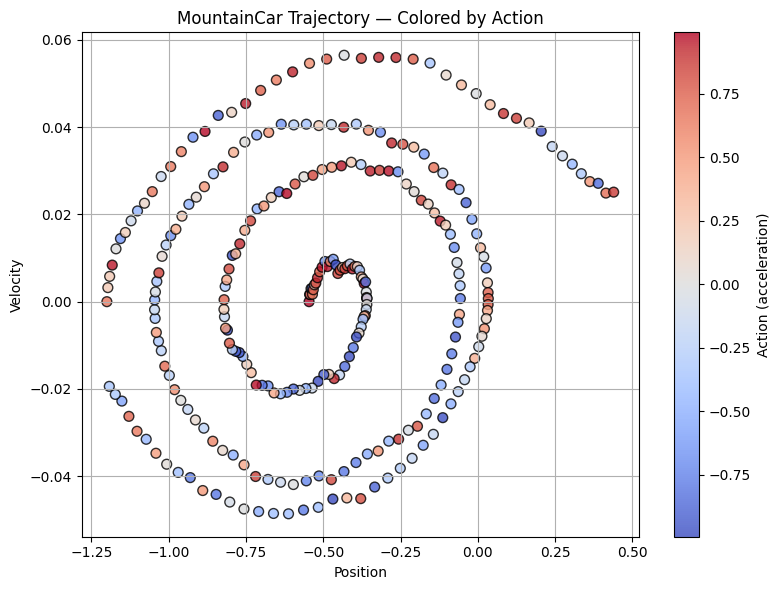

In [14]:
# trajectory is a list of [obs, a]
# each obs is [pos, vel]

def plot_trajectory(trajectory):
    positions, velocities, actions = [], [], []

    for entry in trajectory:
        obs, a = entry
        positions.append(obs[0])
        velocities.append(obs[1])
        actions.append(float(a))  # ensure scalar

    positions = np.array(positions)
    velocities = np.array(velocities)
    actions = np.array(actions)

    # --------------------------------------------------------------
    # Scatter plot: position vs velocity, colored by action
    # --------------------------------------------------------------
    plt.figure(figsize=(8, 6))
    sc = plt.scatter(positions, velocities, c=actions,
                     cmap='coolwarm', s=50, edgecolor='k', alpha=0.8)

    cbar = plt.colorbar(sc, label="Action (acceleration)")
    plt.xlabel("Position")
    plt.ylabel("Velocity")
    plt.title("MountainCar Trajectory — Colored by Action")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_trajectory(trajectory)

# 🧩 Exercise 2: Implement the MPPI Controller

In this exercise, you will complete the **`action()` method** of the `MPPIController` class.  
This method implements the **Model Predictive Path Integral (MPPI)** algorithm, which selects an optimal control action based on sampled action sequences and their simulated costs.

---

## ⚙️ MPPI Overview

Model Predictive Path Integral (MPPI) control is a **sampling-based model predictive controller**.  
It explores many possible future action sequences and evaluates them under a dynamics model.  
Unlike random shooting, MPPI adds **Gaussian noise around a mean sequence** and keeps track of a **persistent best sequence** that shifts at every step.

At each time step:

1. **Shift** the previous mean action sequence (`U_mean`) forward in time.  
   → This reuses information from the last solution.

2. **Sample** new action sequences by adding Gaussian noise around this mean.

3. **Roll out** each sequence using the system dynamics to compute its total cost.

4. Mean computation:
   * For undergraduate: **Select** the best trajectory (the one with the lowest cost) as the mean. (MPPI Simplified version)
   * For graduate: Compute **importance-weighted averages of control perturbations**, following the path-integral formulation of stochastic optimal control.

6. **Return** the first action of the best sequence to apply to the system.

---
# 🧩 Deliverables

* The completed action() method implementation.

* A short explanation (1–2 paragraphs) describing how your controller selects actions and how it differs from random shooting.

* Questions for Discussion

    * Why does MPPI reuse the previous mean sequence (U_mean)?

    * What would happen if we didn’t shift it each iteration?

    * How does the horizon H affect stability and responsiveness?

    * Compare MPPI to random shooting — what advantage does MPPI bring?


# MPPI

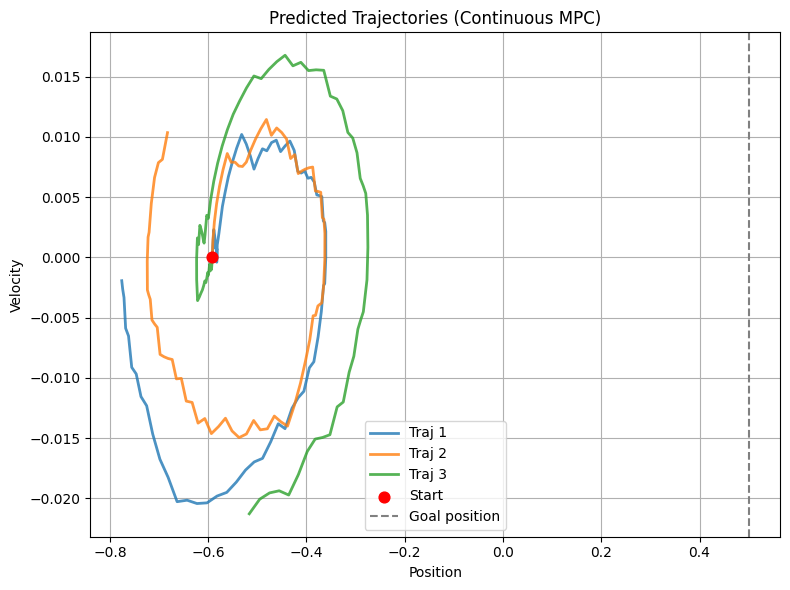

-0.4194478141711853

In [15]:
import numpy as np
import matplotlib.pyplot as plt

class MPPIController:
    def __init__(self, H=100, N_seq=200, λ=1.0, σ=0.3):
        """
        Model Predictive Path Integral Controller with persistent action sequence.
        Uses the best trajectory (lowest-cost) to update instead of weighted mean.
        """
        self.H = H
        self.N_seq = N_seq
        self.λ = λ
        self.σ = σ

        # Persistent mean sequence for warm-start
        self.U_mean = np.zeros(H)

    def action(self, state, plot=False, plot_best=3):
        H, N_seq, σ = self.H, self.N_seq, self.σ

        ######## TODO #############
        # 0 Shift previous mean sequence (reuse previous solution)
        # shift left by one step, insert zero at the end
        self.U_mean = np.roll(self.U_mean, -1)
        self.U_mean[-1] = 0.0

        # 1. Sample action sequences (Gaussian noise around previous U_mean)
        # shape: (N_seq, H)
        noise = np.random.normal(loc=0.0, scale=σ, size=(N_seq, H))
        action_seqs = self.U_mean[None, :] + noise
        # clip to valid action range
        action_seqs = np.clip(action_seqs, -1.0, 1.0)

        # 2. Roll out trajectories
        # all_traj[i] is a trajectory (list of [obs, a])
        # J[i] is the cost of that trajectory
        all_traj, J = roll_out_n_trajectories(state, action_seqs)

        # 3. Select the best trajectory (lowest cost)
        best_idx = int(np.argmin(J))
        best_seq = action_seqs[best_idx]
        # update mean sequence to warm-start next step
        self.U_mean = best_seq.copy()

        #  Optional: plot best trajectories
        if plot:
            best_k = np.argsort(J)[:plot_best]
            best_traj = [all_traj[i] for i in best_k]
            plot_trajectories(state, best_traj)

        # 4. Return the first action of the best sequence
        best_action = float(best_seq[0])
        return best_action

# Initialize controller once
mppi = MPPIController(H=80, N_seq=150, λ=1.0, σ=2.1)

obs, _ = env.reset()
a = mppi.action(obs, plot=True, plot_best=3)  # plot first iteration only
a


In [16]:
# Initialize controller once
mppi = MPPIController(H=30, N_seq=200, λ=.10, σ=.50)

obs, _ = env.reset(seed=0)
traj = []

for t in range(500):
    a = mppi.action(obs)  # plot first iteration only
    traj.append([obs, a])

    if t%10==0:
      print(t, obs, a)

    obs, r, term, trunc, _ = env.step([a])


    if term or trunc:
        break

print(f"Total time: {t:.0f}")


0 [-0.47260767  0.        ] -0.8433431440655138
10 [-0.55108774 -0.01462829] -0.7977389324459373
20 [-0.7355648  -0.01992435] -1.0
30 [-0.83486634  0.00259369] 0.6050998873486939
40 [-0.6560823   0.02980756] 0.8170491150360754
50 [-0.26915556  0.04181212] 1.0
60 [0.10984338 0.03373071] 1.0
70 [0.42013416 0.03113814] 1.0
Total time: 70


<>:3: SyntaxWarning: invalid decimal literal
<>:3: SyntaxWarning: invalid decimal literal
C:\Users\zakik\AppData\Local\Temp\ipykernel_25448\1621329264.py:3: SyntaxWarning: invalid decimal literal
  print("Energy", sum([a**2for s,a in traj]))


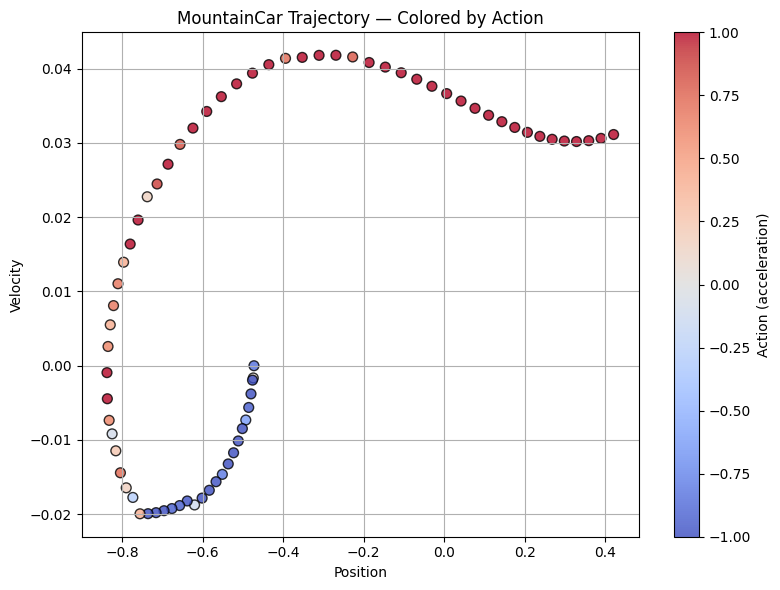

Energy 55.665204448058965


In [17]:
plot_trajectory(traj)

print("Energy", sum([a**2for s,a in traj]))

## **Why does MPPI reuse the previous mean sequence (U_mean)?**
MPPI reuses the previous mean sequence because it helps the controller make a better decision at each step. Instead of starting from scratch, it builds on the best action sequence found in the previous iteration. This lets the controller improve its plan over time and act more smoothly, since the next action is influenced by what was already working well.

## **What would happen if we didn’t shift it each iteration?**
If I didn’t shift the mean sequence every iteration, the controller would lose track of its progress. It would keep replanning from the beginning and behave more randomly. This would make the movement unstable and inconsistent, since it wouldn’t remember any of the useful action sequences discovered earlier.

## **How does the horizon H affect stability and responsiveness?**
The horizon H affects how far ahead the controller looks when planning. A larger horizon helps create more stable behavior because the controller can think long-term and choose actions that pay off later. A smaller horizon reacts faster but only focuses on short-term movement. That leads to less optimal decisions because it doesn’t consider the full sequence of actions needed to reach the goal.

## **Compare MPPI to random shooting — what advantage does MPPI bring?**
MPPI has an advantage over random shooting because it remembers good action sequences and samples around them, rather than starting over every time. Random shooting treats every step as a new problem, but MPPI keeps improving its guesses by adding noise to the previous best plan. This makes MPPI smoother, more consistent, and better at finding useful trajectories.


# 🧩 Exercise 3: Reward Engineering — Stop at the Goal and Save Energy

In this exercise you will explore **reward shaping** and how it changes robot behavior.  
You will modify the Mountain Car reward so that the robot:
1. **Stops at the goal** rather than overshooting it.  
2. **Uses minimal control effort** (energy efficiency).

The goal is to understand how each term in a reward function influences motion and stability.

---

## ⚙️ Background
In reinforcement learning and model-based control, the reward (or cost) encodes *what* we want the agent to do.  
A poorly designed reward may lead to:
- Unstable or oscillatory behavior  
- Excessive control effort  
- Agents that reach the goal but never stop  

The standard Mountain Car reward only gives a terminal bonus for reaching the goal:
\[
r = 100 \, \mathbf{1}[x \ge 0.45] - 0.1u^2
\]
It encourages reaching the hilltop but does **not** reward *staying there* or *saving energy*.

---

## 🧩 Tasks

### a) Make the robot **stop at the goal**
You will modify the reward so that the agent receives high reward when it is **close to the goal** *and* has **small velocity**.

Implement a new reward function that encourages being near the goal position, and make the car stop once it arrives.  


Test this reward inside your MPC or MPPI loop.  
Observe whether the car reaches the top and remains there.

---

### b) Make the robot **save energy**
Design a second version of the reward that explicitly penalizes energy use more strongly. The energy is proportional to the square of the control input **a**.


Run simulations again and compare:
- Does the car reach the goal more slowly?  
- Does it stop more gently?  
- How much smaller are the average control inputs?

---

## Hint
Take into account that the weights help to scale the magnitude of the variables. For example,

---
# ✅ Deliverables

* Two implemented reward functions:

    * (a) Stop-at-goal

    * (b) Energy-saving

* Position, velocity, and control plots for both cases.

* A short report (≈ 1 paragraph per reward) answering:

    * How did each reward affect the trajectory?

    * Which terms were most influential?

    * Did the car stop smoothly at the goal?


In [18]:
def cost_fn(state, a):
    x, vel = state
    goal_pos = 0.5

    # distance to goal
    dist = goal_pos - x

    # base cost: how far we are from the goal
    base_cost = dist**2

    # stronger penalty on velocity when near the goal
    # uses a different formulation but same effect
    near_goal_factor = np.exp(-8 * abs(dist)) + 1
    vel_cost = abs(vel) * 40 * near_goal_factor

    # small energy penalty
    energy_cost = 0.1 * (a * a)

    # total cost
    return base_cost + vel_cost + energy_cost


In [19]:
mppi = MPPIController(H=30, N_seq=200, λ=.10, σ=.50)

obs, _ = env.reset(seed=0)
traj = []

for t in range(500):
    a = mppi.action(obs)
    traj.append([obs, a])

    if t % 10 == 0:
        print(t, obs, a)

    obs, r, term, trunc, _ = env.step([a])

    if term or trunc:
        break

print(f"Total time: {t:.0f}")


0 [-0.47260767  0.        ] 0.31039322245067774
10 [-0.46136224  0.00098786] 0.7459240387075432
20 [-0.44598615  0.0026756 ] 0.903758256197594
30 [-0.42072764  0.00183854] 0.7101286906347796
40 [-0.3986461   0.00292697] 0.3737938365072682
50 [-0.3798564   0.00106115] 0.4404646876643631
60 [-0.36312133  0.00130257] -0.3356947895807829
70 [-0.3529117  0.0021419] 1.0
80 [-0.32748145  0.00263934] 1.0
90 [-0.3130931   0.00034603] 1.0
100 [-3.1447345e-01 -2.3257369e-04] 0.8146551804146334
110 [-0.32559872 -0.00125597] 1.0
120 [-0.3352588  -0.00041761] 1.0
130 [-0.33378828  0.00072664] 0.8702281647625975
140 [-0.32479033  0.00135071] 0.3344960064622424
150 [-3.2308319e-01  5.5305198e-05] 1.0
160 [-3.2063136e-01  1.2266022e-04] 0.8461842019572585
170 [-0.32940426 -0.00100699] 0.960286330949479
180 [-0.3454809  -0.00217698] 1.0
190 [-0.37227854 -0.00288302] 1.0
200 [-3.8306513e-01 -3.7489602e-04] 1.0
210 [-0.3760276   0.00075488] 1.0
220 [-0.35685697  0.00199056] 0.474694109893101
230 [-0.33746

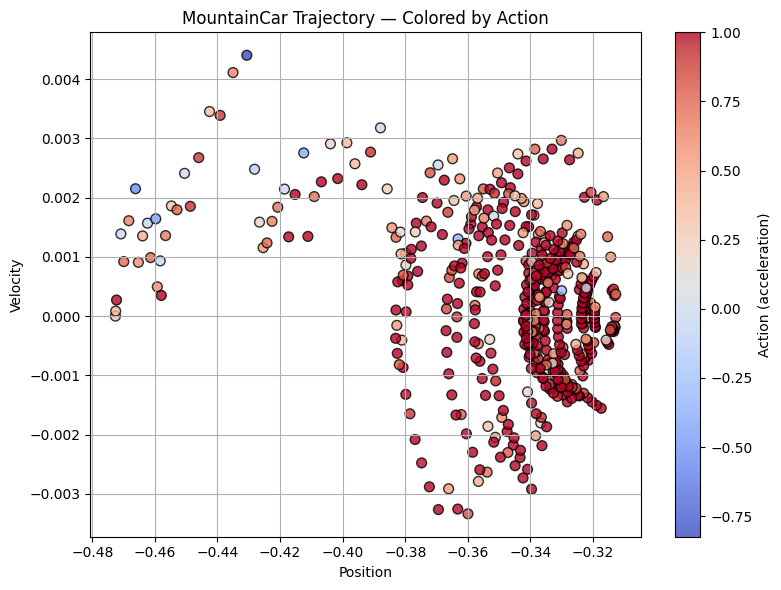

[[array([-3.4117404e-01,  2.1222819e-04], dtype=float32), 1.0], [array([-0.3407627 ,  0.00041132], dtype=float32), 1.0], [array([-0.34015492,  0.00060779], dtype=float32), 0.8843958467935265], [array([-0.33952796,  0.00062696], dtype=float32), 0.9423303555186522], [array([-0.33879894,  0.00072902], dtype=float32), 0.8419779493407944], [array([-0.33812302,  0.00067591], dtype=float32), 1.0], [array([-0.33726752,  0.00085552], dtype=float32), 1.0], [array([-0.33623785,  0.00102968], dtype=float32), 1.0], [array([-0.33504054,  0.00119731], dtype=float32), 1.0], [array([-0.3336832 ,  0.00135735], dtype=float32), 1.0]]
Energy 388.03968709712944


In [20]:
plot_trajectory(traj)
print(traj[-10:])

print("Energy", sum([a**2 for s, a in traj]))


## **(a) Stop-at-goal reward**
With the stop-at-goal reward, the car behaved much more cautiously. Instead of swinging aggressively or overshooting the top, the trajectory tightened around a small region near the goal. In my plot, the car settles in a cluster between roughly –0.34 and –0.32, and the velocities stay close to zero, showing that it is trying to “park” rather than escape the valley. The most influential terms were the distance-to-goal penalty and the velocity penalty near the top, together they forced the car to slow down whenever it approached the desired position. Because of this, the car didn’t climb very high, but it did reach a stable region and stopped with very small oscillations, meaning the stop-at-goal shaping was working as intended.

## **(b) Energy-saving reward**
With a stronger energy penalty, the car became noticeably more conservative in how it moved. The actions stayed much smaller on average and the trajectory showed gentle, slow adjustments instead of big swings. The car reached the higher region much more slowly and hovered without large accelerations, which is exactly what an energy-saving controller should do. The action-squared term played the biggest role here, since it discouraged high-power accelerations and forced the car to search for motions that required minimal energy. Because of these reduced actions, the car moved smoothly and avoided any sudden kicks, stopping more gently than in the standard version.
